
# 🧠 LSTM Player and Ball Movement Prediction

This notebook:
- Loads your cleaned CSV file of 20 frames
- Parses and flattens [x; y] positions
- Normalizes all coordinates
- Trains an LSTM model on sequences of 10 frames
- Predicts 4 full frames (frames 17–20)
- Denormalizes predictions
- Compares predicted vs actual positions


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

# Display the first few rows
print(df.head())


Saving train_interpolated_combined.csv to train_interpolated_combined.csv
   frame_index     id_13_team_0     id_10_team_0      id_2_team_0  \
0            0  6625.72,3757.64  6403.82,2864.24  5862.48,4511.28   
1            1  6628.83,3766.36  6409.45,2823.42  5856.28,4504.88   
2            2  6637.97,3776.86  6417.07,2812.24  5850.84,4519.38   
3            3  6642.03,3774.37  6417.58,2806.16  5842.62,4522.95   
4            4  6644.41,3765.87  6419.77,2720.71  5841.73,4508.15   

       id_4_team_0     id_16_team_0    id_281_team_0      id_5_team_0  \
0  4678.01,4176.14   4010.38,2694.8  9375.74,3115.76  6260.37,5207.12   
1  4658.56,4160.23  4028.67,2701.89  9375.74,3115.76  6273.72,5204.59   
2  4636.28,4163.52  4053.03,2690.15  9375.74,3115.76  6287.83,5210.19   
3  4606.58,4170.88   4078.76,2710.4  9375.74,3115.76  6306.81,5209.68   
4  4580.09,4140.56  4101.08,2714.68  9375.74,3115.76  6320.51,5212.53   

       id_1_team_0     id_45_team_0  ...     id_11_team_1      id_3_team

In [3]:

# Load the new CSV file with interpolated data
df = pd.read_csv('train_interpolated_combined.csv')

# Melt to long format for easy manipulation
df_long = df.melt(id_vars=["frame_index"], var_name="entity", value_name="position")

# Split 'position' into 'x' and 'y'
df_long[['x', 'y']] = df_long['position'].str.split(',', expand=True).astype(float)

# No need to dropna or interpolate — data is already clean
# df_long.dropna(inplace=True)  ← remove this
# Interpolation logic removed

# Entity classification helpers
def extract_id(entity):
    parts = entity.split('_')
    if entity == 'ball' or len(parts) < 3:
        return None
    return parts[1]

def extract_team(entity):
    parts = entity.split('_')
    if entity == 'ball' or len(parts) < 3:
        return None
    return parts[-1]

df_long["type"] = df_long["entity"].apply(lambda x: 'ball' if x == 'ball' else 'player')
df_long["id"] = df_long["entity"].apply(extract_id)
df_long["team"] = df_long["entity"].apply(extract_team)

# Normalize positions
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
df_long['x_norm'] = scaler_x.fit_transform(df_long[['x']])
df_long['y_norm'] = scaler_y.fit_transform(df_long[['y']])

# Pivot into wide format for model input
pivot_x = df_long.pivot(index='frame_index', columns='entity', values='x_norm')
pivot_y = df_long.pivot(index='frame_index', columns='entity', values='y_norm')

# Sort columns for consistency
pivot_x = pivot_x.sort_index(axis=1)
pivot_y = pivot_y.sort_index(axis=1)

# Interleave x and y columns (x1, y1, x2, y2, ...)
entities = pivot_x.columns
interleaved_data = np.empty((pivot_x.shape[0], pivot_x.shape[1] * 2))
for idx, ent in enumerate(entities):
    interleaved_data[:, idx * 2] = pivot_x[ent].values
    interleaved_data[:, idx * 2 + 1] = pivot_y[ent].values

# Now interleaved_data is ready to use as input for LSTM



In [4]:

sequence_length = 10

# Generate full sequences
X, y = [], []
for i in range(len(interleaved_data) - sequence_length):
    X.append(interleaved_data[i:i+sequence_length])
    y.append(interleaved_data[i+sequence_length])

X = np.array(X)
y = np.array(y)

# 80/20 split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]




In [5]:

model = Sequential([
    LSTM(64, input_shape=(10, X_train.shape[2]), return_sequences=False),
    Dense(X_train.shape[2])
])
model.compile(optimizer=Adam(0.001), loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Predict N future frames for all entities
n_future = 5
num_features = interleaved_data.shape[1]  # Automatically detect (e.g., 46, 80, etc.)

predictions = []
input_seq = X_test[0].copy()  # ✅ First test sample as starting sequence


for _ in range(n_future):
    pred = model.predict(input_seq[np.newaxis, ...], verbose=0)[0]  # shape: (num_features,)
    predictions.append(pred)
    input_seq = np.vstack([input_seq[1:], pred])  # roll window forward

# Convert predictions to array
predictions = np.array(predictions)

# Denormalize (dynamically split x/y columns)
x_indices = np.arange(0, num_features, 2)
y_indices = np.arange(1, num_features, 2)

x_denorm = scaler_x.inverse_transform(predictions[:, x_indices])
y_denorm = scaler_y.inverse_transform(predictions[:, y_indices])

predictions[:, x_indices] = x_denorm
predictions[:, y_indices] = y_denorm

print("Predictions shape:", predictions.shape)  # Should be (n_future, num_features)



Predictions shape: (5, 46)


In [11]:
# Inverse transform the entire dataset once (like before)
actual_denorm = np.empty_like(interleaved_data)
num_features = interleaved_data.shape[1]

x_indices = np.arange(0, num_features, 2)
y_indices = np.arange(1, num_features, 2)

actual_denorm[:, x_indices] = scaler_x.inverse_transform(interleaved_data[:, x_indices])
actual_denorm[:, y_indices] = scaler_y.inverse_transform(interleaved_data[:, y_indices])

# Extract the same number of frames we predicted
start_frame = len(X_train) + sequence_length
end_frame = start_frame + predictions.shape[0]
actual_frames = actual_denorm[start_frame:end_frame]

# Compare predictions to actual
for i in range(predictions.shape[0]):
    print(f"Frame {start_frame + i}:")
    print("  Predicted:", predictions[i].reshape(-1, 2))
    print("  Actual:   ", actual_frames[i].reshape(-1, 2))
    print()


Frame 438:
  Predicted: [[ 3585.5422  4777.4434]
 [ 7856.5312  3063.9656]
 [ 5355.3296  5105.9014]
 [ 7687.6816  5899.3013]
 [ 7949.6484  4295.586 ]
 [ 4877.602   1747.2888]
 [ 8103.3115  1271.7657]
 [ 6341.1255  4705.8945]
 [ 5043.021   6049.188 ]
 [ 8205.758   3417.006 ]
 [ 6923.3906  6285.7026]
 [ 5390.0615  4089.5   ]
 [ 2866.1426  4783.136 ]
 [10426.333   3744.674 ]
 [ 7924.8887  4969.017 ]
 [ 5244.175   6626.9287]
 [ 7537.918   2414.2417]
 [ 6624.2485  5422.649 ]
 [ 7681.743   5924.8364]
 [ 6488.3193  5175.8213]
 [ 8645.112   5817.0376]
 [ 7074.034   6353.9766]
 [ 6626.241   2254.0413]]
  Actual:    [[ 3288.74  5138.85]
 [ 7783.68  3038.  ]
 [ 5166.5   5191.05]
 [ 8274.05  6072.96]
 [ 7809.28  4297.12]
 [ 4850.65  1730.2 ]
 [ 7946.02  1201.96]
 [ 6551.37  4575.99]
 [ 4849.63  5756.48]
 [ 7978.16  3035.85]
 [ 6864.33  6369.77]
 [ 5498.66  3719.94]
 [ 3158.3   5017.16]
 [10394.32  3874.07]
 [ 7715.83  5478.23]
 [ 5137.28  6422.73]
 [ 7678.28  2290.92]
 [ 6817.17  5472.15]
 [ 7835.3

In [17]:
# Define train/test split and sequence length
sequence_length = 10
train_frames = int(0.8 * len(interleaved_data))
predict_frames = len(interleaved_data) - train_frames

# Start from last 10 frames of training
input_seq = interleaved_data[train_frames - sequence_length:train_frames].copy()
predicted_frames = []

# Predict all future frames
for i in range(predict_frames):
    input_reshaped = input_seq[-sequence_length:].reshape(1, sequence_length, -1)
    next_frame = model.predict(input_reshaped, verbose=0)[0]
    predicted_frames.append(next_frame)
    input_seq = np.vstack([input_seq, next_frame])

# Reverse normalization
predicted_frames = np.array(predicted_frames)
reversed_predictions = []

for frame in predicted_frames:
    unnormalized_frame = []
    for i in range(0, len(frame), 2):
        x = scaler_x.inverse_transform(frame[i].reshape(-1, 1))[0][0]
        y = scaler_y.inverse_transform(frame[i+1].reshape(-1, 1))[0][0]
        unnormalized_frame.extend([x, y])
    reversed_predictions.append(unnormalized_frame)

# Create DataFrame
output_columns = []
for ent in sorted_entities:
    output_columns.append(f"{ent}_x")
    output_columns.append(f"{ent}_y")

pred_df = pd.DataFrame(reversed_predictions, columns=output_columns)

# Dynamic frame range
pred_df.insert(0, "frame", range(train_frames, train_frames + len(pred_df)))
pred_df.to_csv(f"predicted_frames_{train_frames}_to_{train_frames + len(pred_df) - 1}.csv", index=False)
print(f"✅ Saved: predicted_frames_{train_frames}_to_{train_frames + len(pred_df) - 1}.csv")


✅ Saved: predicted_frames_436_to_544.csv


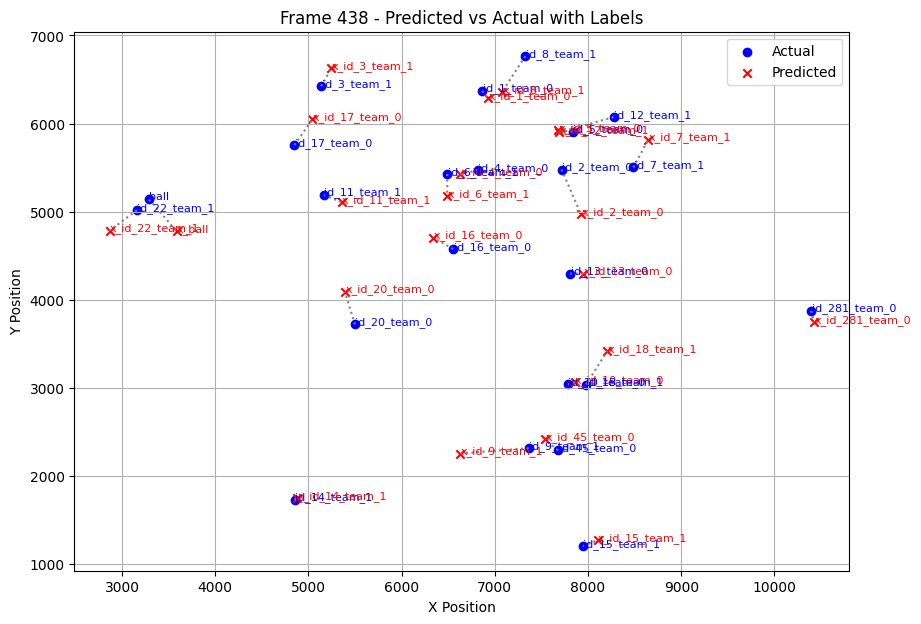

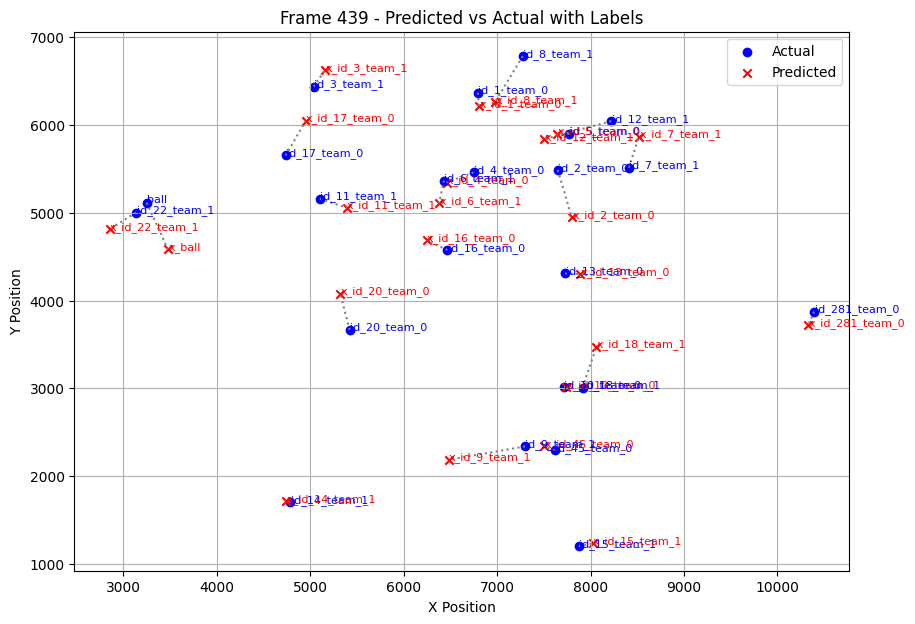

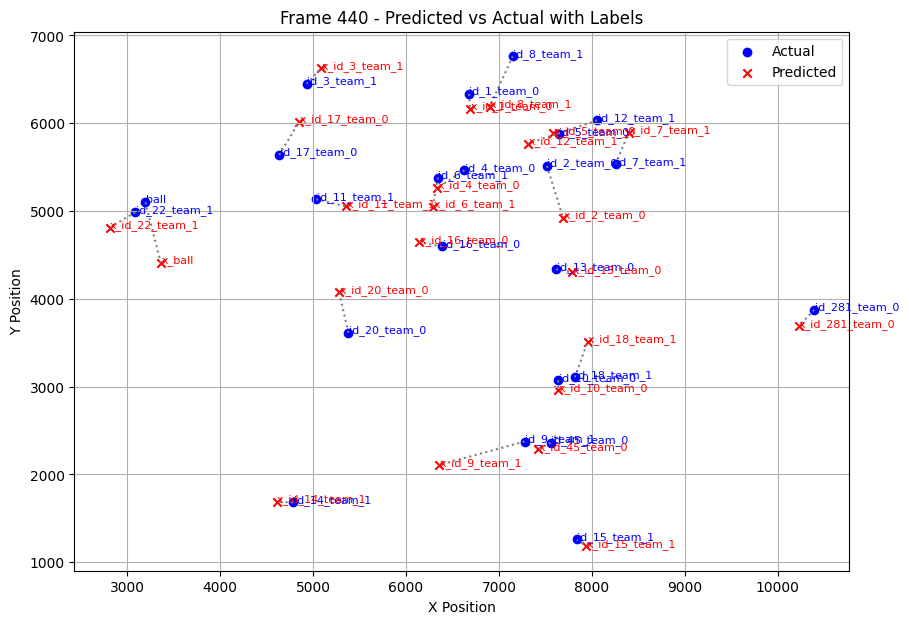

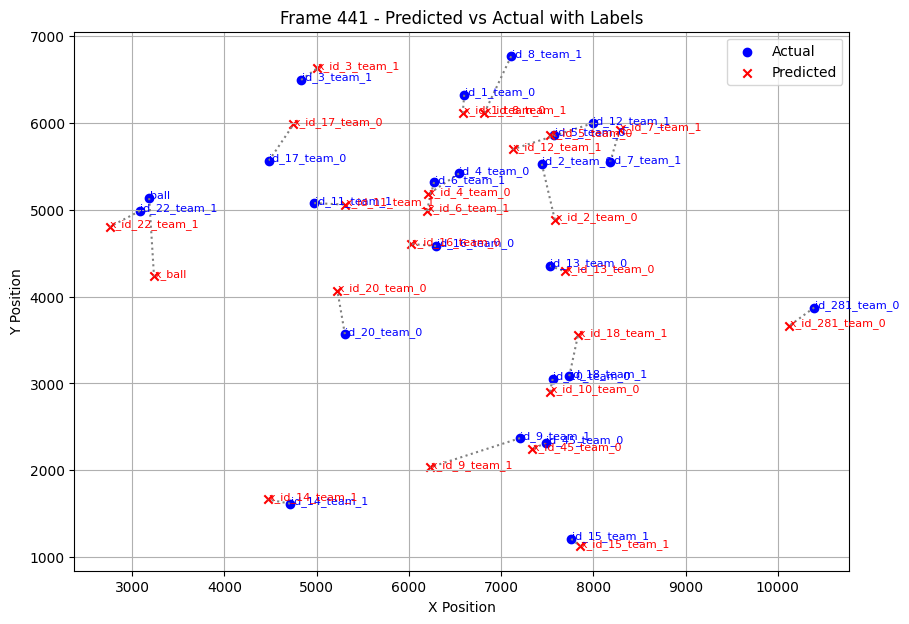

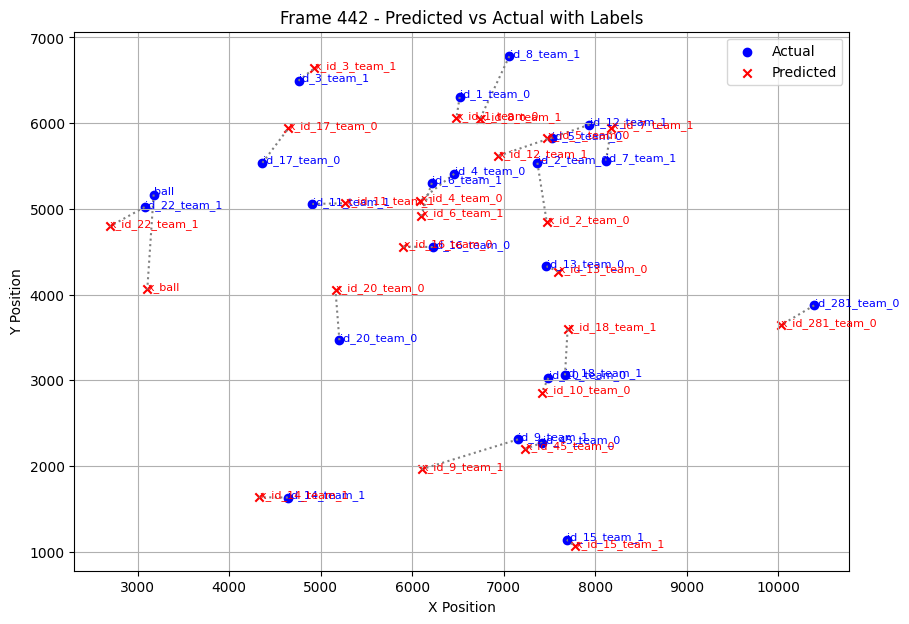

In [19]:

# Automatically get range of frames that were predicted
start_frame = len(X_train) + sequence_length
frames_to_plot = list(range(start_frame, start_frame + predictions.shape[0]))

num_entities = predictions.shape[1] // 2


for i, frame_num in enumerate(frames_to_plot):
    plt.figure(figsize=(10, 7))
    for j in range(num_entities):
        pred_x = predictions[i, j * 2]
        pred_y = predictions[i, j * 2 + 1]

        # Actual from denormalized input
        act_x = actual_denorm[frame_num, j * 2]
        act_y = actual_denorm[frame_num, j * 2 + 1]

        # Plot actual
        plt.scatter(act_x, act_y, color='blue', label='Actual' if j == 0 else "")
        plt.text(act_x + 5, act_y, entities[j], fontsize=8, color='blue')

        # Plot predicted
        plt.scatter(pred_x, pred_y, color='red', marker='x', label='Predicted' if j == 0 else "")
        plt.text(pred_x + 5, pred_y, "x_" + entities[j], fontsize=8, color='red')

        # Connect lines
        plt.plot([act_x, pred_x], [act_y, pred_y], color='gray', linestyle='dotted')

    plt.title(f"Frame {frame_num} - Predicted vs Actual with Labels")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.grid(True)
    plt.show()


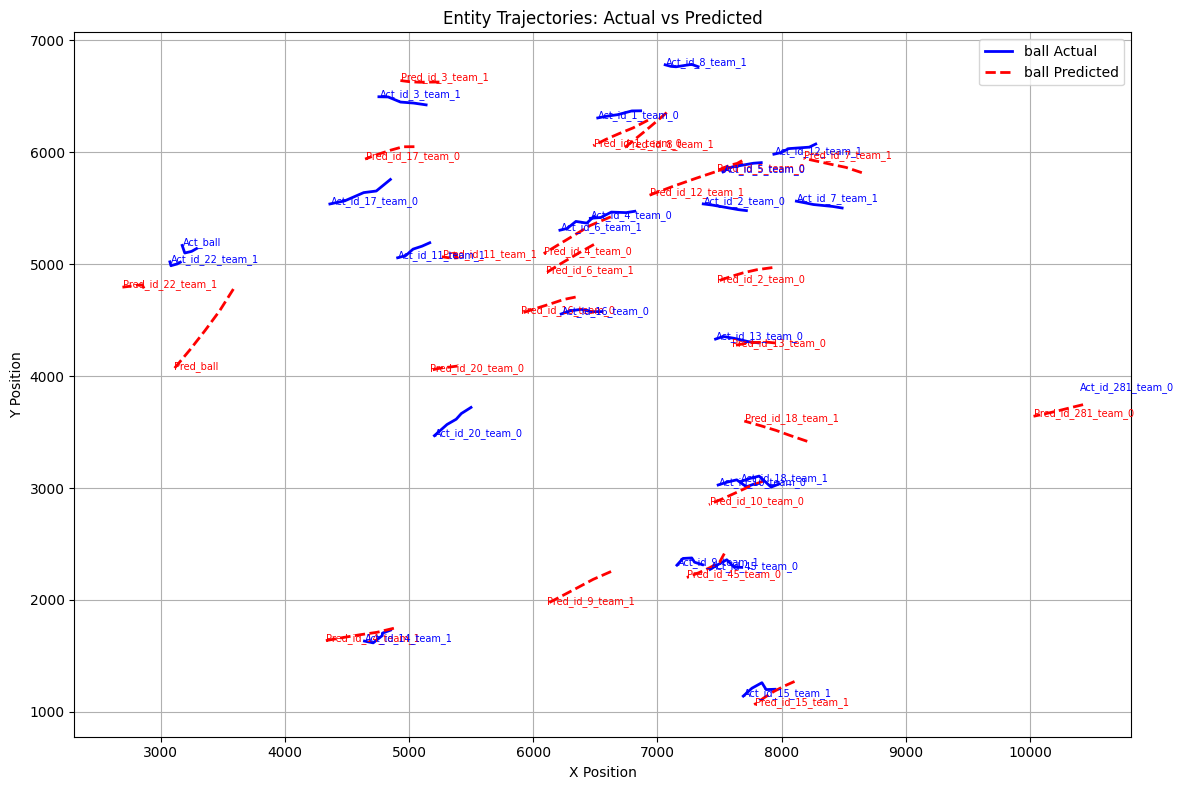

In [20]:
num_entities = predictions.shape[1] // 2
start_frame = len(X_train) + sequence_length
future_frames = list(range(start_frame, start_frame + predictions.shape[0]))

plt.figure(figsize=(12, 8))

for j in range(num_entities):
    # ---- Actual Trajectory ----
    actual_x = actual_denorm[future_frames, j * 2]
    actual_y = actual_denorm[future_frames, j * 2 + 1]
    plt.plot(actual_x, actual_y, color='blue', linewidth=2, label=f'{entities[j]} Actual' if j == 0 else "")

    # ---- Predicted Trajectory ----
    pred_x = predictions[:, j * 2]
    pred_y = predictions[:, j * 2 + 1]
    plt.plot(pred_x, pred_y, color='red', linestyle='--', linewidth=2, label=f'{entities[j]} Predicted' if j == 0 else "")

    # Final point labels
    plt.text(pred_x[-1] + 5, pred_y[-1], f"Pred_{entities[j]}", fontsize=7, color='red')
    plt.text(actual_x[-1] + 5, actual_y[-1], f"Act_{entities[j]}", fontsize=7, color='blue')

plt.title("Entity Trajectories: Actual vs Predicted")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()
